In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10000)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
#%%


# %%
# INDOORS 1 SUN
file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')# the whole excel file 
sn = file.sheet_names # sheets that are the excel file 
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl') # read the data from the first sheet 

temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy() #take the temperature from the row Annealing temperature of column Parameters and convert it to numpy
temperature = temperature[2,2:] # take everything from temperature starting from the third row and the third column
 
devices = data_frame.columns.to_numpy() # take the devices from the data and convert them to numpy
 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:] #excluding the first two elements

time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl') # read the data from the last sheet

time_series_df = time_series_df.drop(index =[0]) # drop the first row (einheiten)
time = time_series_df.iloc[:,0] # take the time from the first column



# print(time)
time_series_1_sun = []
for i in range (temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:,2+i*3]) ### for every device take the impp (optimal current output that the solar panel can generate when it is operating at its maximum power point)

time_series_1_sun = np.array(time_series_1_sun) # convert it to array [shape(24, 4001)]


# %% 
# 1.4 SUN

file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')

# temperature
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]

# print(time)
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,2+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun)#[shape(24, 1313)]



# %%
# %%
# OUTDOOR CONDITIONS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')

irradiance = outdoor_conditions['irradiance'] #[shape(4794,)]
rh = outdoor_conditions['rh'] #[shape(4794,)]
 
outdoor_temperature = outdoor_conditions['outdoor_temperature'] #[shape(4794,)]

outdoor_condition_time = outdoor_conditions['time'] #[shape(4794,)] 
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
scaler = MinMaxScaler()
 
# Normalize irradiance column
irradiance_normalized = scaler.fit_transform(outdoor_conditions['irradiance'].values.reshape(-1, 1))

# Normalize rh column
rh_normalized = scaler.fit_transform(outdoor_conditions['rh'].values.reshape(-1, 1))

# Normalize outdoor_temperature column
outdoor_temperature_normalized = scaler.fit_transform(outdoor_conditions['outdoor_temperature'].values.reshape(-1, 1))

# Create a new DataFrame with normalized columns
outdoor_conditions_normalized = pd.DataFrame({
    'irradiance_normalized': irradiance_normalized.flatten(),
    'rh_normalized': rh_normalized.flatten(),
    'outdoor_temperature_normalized': outdoor_temperature_normalized.flatten(),
    'time': outdoor_conditions['time']
})

# Save the normalized DataFrame to a new file
outdoor_conditions_normalized.to_csv('outdoor_conditions_normalized.txt', sep='\t')
outdoor_conditions_normalized=pd.read_csv('outdoor_conditions_normalized.txt', sep='\t')
# %%
# OUTDOOR PANELS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
# outdoor_panels.head()
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power) #[shape(24, 4794)]

#%%
# Padding


time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_sun = np.pad(time_series_1_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])),mode='edge')    
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' )    
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0],time_series_1_sun.shape[1],1)))
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))
 

In [3]:
# Calculate average values for time_series_1_sun
time_series_1_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i-1:i+1], axis=0)
        j += 1
 
     

# Calculate average values for time_series_1_4_sun
time_series_1_4_sun_average = np.zeros((12, 4794, 1))
k = 0
for i in range(time_series_1_4_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_4_sun_average[k] = np.mean(time_series_1_4_sun[i-1:i+1], axis=0)
        k += 1

# Calculate average values for outdoor_panels_power
outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0 # Set negative values to 0
        b += 1

# Stack the outdoor conditions
outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 12, axis=0)
outdoor_conditions_stacked_2= np.stack([outdoor_conditions] * 20, axis=0)




In [4]:
window_size = 30  # Adjust the window size as per your requirements

time_series_1_sun_average_ma = np.zeros((12, 4794, 1))
for panel in range(12):
    for point in range(4794):
        if point < window_size-1:
            # If there are not enough previous points, use the current value
            time_series_1_sun_average_ma[panel, point] = time_series_1_sun_average[panel, point]
        else:
            # Compute the moving average using the previous window_size points
            average = np.mean(time_series_1_sun_average[panel, point-window_size+1:point+1])
            time_series_1_sun_average_ma[panel, point] = average

time_series_1_sun_average_global_diff = np.zeros((12, 4794, 1))
for panel in range(12):
    global_mean = np.mean(time_series_1_sun_average[panel])
    time_series_1_sun_average_global_diff[panel] = time_series_1_sun_average[panel] - global_mean

window_size = 10  # Adjust the window size as per your requirements
ema_values = np.zeros((12, 4794, 1))
# Compute EMA for each panel
for panel_idx in range(ema_values.shape[0]):
    panel_data = pd.Series(time_series_1_sun_average[panel_idx, :, 0])
    ema = panel_data.ewm(span=window_size).mean()
    ema_values[panel_idx, :, 0] = ema.values


fourier_transform = np.fft.fft(time_series_1_sun_average, axis=1)
frequencies = np.fft.fftfreq(time_series_1_sun_average.shape[1])
magnitudes = np.abs(fourier_transform)
magnitudes_db = 20 * np.log10(magnitudes)
all_new_features = np.concatenate((time_series_1_sun_average , outdoor_conditions_stacked), axis=2)
print(all_new_features.shape)
print(outdoor_panels_power_average.shape)

(12, 4794, 6)
(12, 4794, 1)


In [5]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Using GPU for computations.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU for computations.')

CUDA is not available. Using CPU for computations.


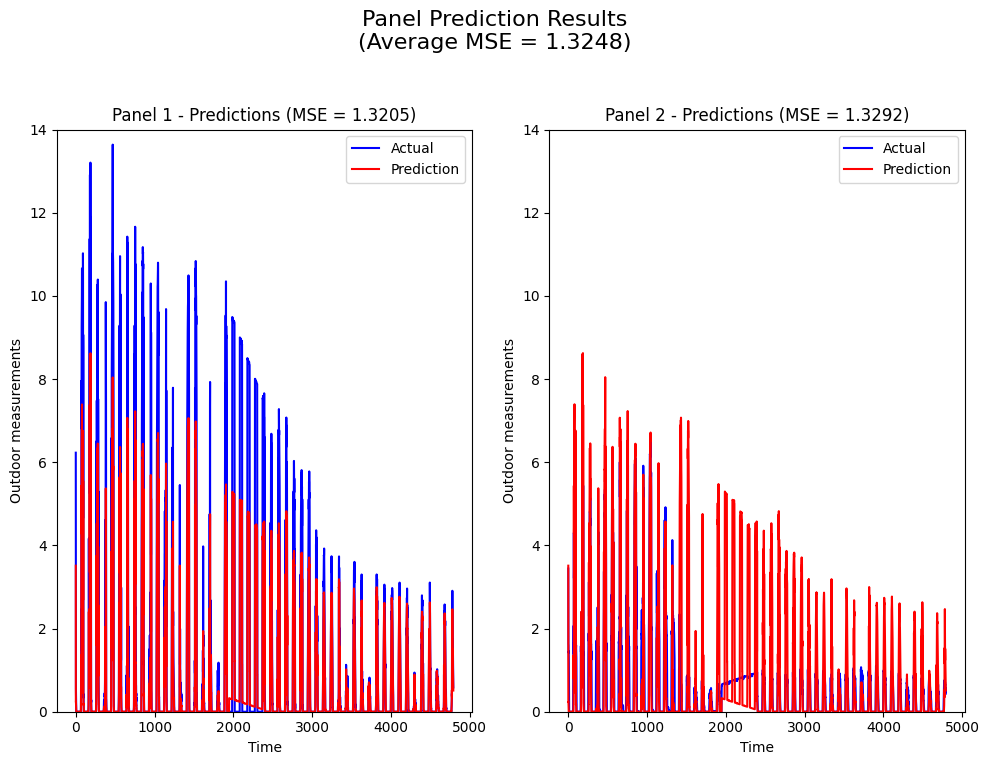

[[3.51149905e+00]
 [2.31788172e-01]
 [2.37029287e-01]
 [1.50844462e-01]
 [4.12385366e-02]
 [4.93398915e-03]
 [2.26915027e-04]
 [4.11678417e-04]
 [9.68197259e-04]
 [3.46287539e-04]]
[[3.51203444e+00]
 [2.31905416e-01]
 [2.36980840e-01]
 [1.50703486e-01]
 [4.12178867e-02]
 [4.93603262e-03]
 [2.26717913e-04]
 [4.11486352e-04]
 [9.56921941e-04]
 [3.46088022e-04]]


In [8]:
# train
num_samples, seq_length, num_features = all_new_features[0:10,:,:].shape
all_new_features_train = all_new_features[0:10,:,:].reshape(num_samples, seq_length * num_features)

num_samples, seq_length, num_features = outdoor_panels_power_average[0:10,:,:].shape
outdoor_panels_power_average_train= outdoor_panels_power_average[0:10,:,:].reshape(num_samples, seq_length * num_features)


# test 
num_samples, seq_length, num_features = all_new_features[10:12,:,:].shape
all_new_features_test = all_new_features[10:12,:,:].reshape(num_samples, seq_length * num_features)

num_samples, seq_length, num_features = outdoor_panels_power_average[10:12,:,:].shape
outdoor_panels_power_average_test= outdoor_panels_power_average[10:12,:,:].reshape(num_samples, seq_length * num_features)


# Define the hyperparameters to search
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],  # List of kernels to try
    'alpha': [0.001, 0.1, 20.0],           # Regularization parameter
    'gamma': [0.0001, 0.1, 20.0],           # Kernel coefficient for 'rbf' and 'poly' kernels
    'degree': [1,2, 3, 4,5],                 # Degree of the polynomial kernel
    'coef0': [-2.0, 0.1, 2.0],            # Independent term for 'poly' kernel
}

# Create the KRR model
krr_model = KernelRidge()

# Create the GridSearchCV object
grid_search = GridSearchCV(krr_model, param_grid, cv=5)  # Use 5-fold cross-validation

# Fit the GridSearchCV to the training data
grid_search.fit(all_new_features_train, outdoor_panels_power_average_train)

# Get the best hyperparameters
best_kernel = grid_search.best_params_['kernel']
best_alpha = grid_search.best_params_['alpha']

# Use the best kernel to create the KRR model with the best hyperparameters
krr_model_best = KernelRidge(kernel=best_kernel, alpha=best_alpha)

# If the best kernel is 'rbf' or 'poly', get the best gamma or degree respectively
if best_kernel in ['rbf', 'poly']:
    best_gamma = grid_search.best_params_['gamma'] if best_kernel == 'rbf' else None
    best_degree = grid_search.best_params_['degree'] if best_kernel == 'poly' else None
    krr_model_best.gamma = best_gamma
    krr_model_best.degree = best_degree

# Train the KRR model with the best hyperparameters
krr_model_best.fit(all_new_features_train, outdoor_panels_power_average_train)

# Predict with the best model
y_pred_best = krr_model_best.predict(all_new_features_test)



# Plot the predictions for each sample in the test set
y_pred_best = y_pred_best.reshape(num_samples, seq_length, num_features)

# Plot the predictions for each sample in the test set
mse_errors = []

fig, axs = plt.subplots(1, 2, figsize=(10, 8))
mse_errors = []  # Initialize the list to store MSE errors

# Iterate over each panel's predictions
for i, ax in enumerate(axs.flat):
    ax.plot(outdoor_panels_power_average_test[i], label='Actual', color='blue')
    ax.plot(y_pred_best[i], label='Prediction', color='red')
    ax.set_xlabel('Time')
    ax.set_ylabel('Outdoor measurements')
    
    # Set the y-axis limits to the desired range
    ax.set_ylim(0, 14) 
    
    # Calculate the Mean Squared Error
    mse = mean_squared_error(outdoor_panels_power_average_test[i], y_pred_best[i])
    mse_errors.append(mse)
    
    # Add the MSE to the title of the plot
    ax.set_title('Panel {} - Predictions (MSE = {:.4f})'.format(i + 1, mse))
    ax.legend()

# Calculate the average MSE
average_mse = np.mean(mse_errors)

# Add a big title for the entire plot with the average MSE
plt.suptitle("Panel Prediction Results\n(Average MSE = {:.4f})".format(average_mse), fontsize=16)
plt.savefig('test_results.pdf')
# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


print(y_pred_best[0, :10])
print(y_pred_best[1, :10])
#1.3237
#1.3391